<a href="https://colab.research.google.com/github/ekolmagorov/StyleTransfer/blob/master/ST_UNET_RESNET18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import os
import torch 


from torchvision.models import resnet as resnet_modules
from torch.optim import Adam
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from collections import OrderedDict
from torch.utils.tensorboard import SummaryWriter
from google.colab import drive

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue May 25 14:30:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
random.seed(123)

DEVICE  = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

4/1AY0e-g5NK5WsDAYsKgpSmzdSWB2ZEAyHPG5Vwo9U7oLE0-Wrg19cnzv13zc4/1AY0e-g5NK5WsDAYsKgpSmzdSWB2ZEAyHPG5Vwo9U7oLE0-Wrg19cnzv13zc

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
% cd /content/drive/MyDrive/курсовая
#! ls

/content/drive/MyDrive/курсовая


In [6]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [7]:
def init_model(model_name, pretrained=False):
    
    if model_name == 'resnet':
        resnet = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=pretrained)
        length = len(list(resnet.children()))
        od = OrderedDict()
        for index, (name, val) in enumerate(resnet.named_children()):
            if index == length - 2:
                break
            if isinstance(val, nn.BatchNorm2d):
                val = Identity()
                
            if isinstance(val, nn.Sequential):
                for ch_name, ch_val in val.named_children():
                    if isinstance(ch_val, resnet_modules.BasicBlock):
                        ch_val.bn1 = Identity()
                        ch_val.bn2 = Identity()
                        if hasattr(ch_val, 'downsample'):
                            downsample = getattr(ch_val, 'downsample')
                            if isinstance(downsample, nn.Sequential):
                                downsample[1]= Identity()
            
            od[name] = val

        od['fin_maxpool'] = nn.MaxPool2d(2)
        model = nn.Sequential(od)

        layers =  ['relu', 'layer1', 'layer2', 'layer3', 'layer4']
        
        channels_sizes = [(512, 512),
                          (512, 256),
                          (256, 128),
                          (128, 64),
                          (64, 64)]

    elif model_name == 'vgg' :
        model = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=pretrained).features
        layers = ['1', '6', '11', '18', '25']
        channels_sizes = [(512, 512),
                        (512, 512),
                        (512, 256),
                        (256, 128),
                        (128, 64)]


    return model, layers, channels_sizes

In [8]:
model, LAYERS_NAME, CHANNELS_SIZES = init_model('resnet', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [9]:
#vgg = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=True).features

In [10]:
#vgg

In [11]:
example_tensor = torch.randn((1, 3, 256, 256))
out = model(example_tensor)
out.shape

torch.Size([1, 512, 4, 4])

In [12]:
class EncoderBlock(nn.Module):

    '''
    Encoder part in Unet-style neural network model
    '''

    def __get_activation(self, name):
        def __hook(module, input, output):
            self.output[name] = output

        return __hook


    def __init__(self, encoder_model, output_layers=None, requires_grad=True):
      super(EncoderBlock, self).__init__()

      self.model = encoder_model
      for param in self.model.parameters():
        param.requires_grad = requires_grad
        
      self.output_layers = output_layers
      self.output = {}

      if output_layers is not None:
        
        for idx, layer_name in enumerate(output_layers):

          if not hasattr(self.model, layer_name):
            raise KeyError("such {} in your encoder model doesn't exist".
                           format(layer_name))

          getattr(self.model, layer_name).register_forward_hook(
              self.__get_activation(layer_name)
              )


    def forward(self, x):

      self.output.clear()
      out = self.model(x)
      self.output['out'] = out
      return out, self.output.copy()

In [13]:
encoder = EncoderBlock(model, LAYERS_NAME)

In [14]:
example_tensor = torch.randn((2, 3, 1024, 1024))
out, d_out = encoder(example_tensor)

In [15]:
for key, value in d_out.items():
    print(key, value.shape)

relu torch.Size([2, 64, 512, 512])
layer1 torch.Size([2, 64, 256, 256])
layer2 torch.Size([2, 128, 128, 128])
layer3 torch.Size([2, 256, 64, 64])
layer4 torch.Size([2, 512, 32, 32])
out torch.Size([2, 512, 16, 16])


In [16]:
class AdainBlock(nn.Module):

    def __init__(self, layers_names):
        super(AdainBlock, self).__init__()
        self.layers_names = layers_names
        self.outputs = {}

    def transform(self, content, style):
        content_size, style_size = content.size(), style.size()
        content_sigma = torch.std(content, dim=(2, 3), keepdims=True)#.expand(content_size)
        style_sigma = torch.std(style, dim=(2, 3), keepdims=True)#.expand(style_size)

        content_mu = torch.mean(content, dim=(2, 3), keepdims=True)#.expand(content_size)
        style_mu = torch.mean(style, dim=(2, 3), keepdims=True)#.expand(style_size)

        
        out = style_sigma * ((content - content_mu)/ (content_sigma + 1e-5)) + style_mu

        return  out

    def forward(self, content_features, style_features):

        self.outputs.clear()

        for layer_name in self.layers_names:

            self.outputs[layer_name] = self.transform(
                                              content_features[layer_name],
                                              style_features[layer_name])
            
        return self.outputs.copy()


In [17]:
example_tensor_c = torch.randn((1, 3, 256, 256))
example_tensor_s = torch.randn((1, 3, 256, 256))

adain = AdainBlock(LAYERS_NAME)

out_c, d_out_c = encoder(example_tensor_c)
out_s, d_out_s = encoder(example_tensor_s)

outputs = adain(d_out_c, d_out_s)
out = adain.transform(out_c, out_s)
for name, value in outputs.items():
    print("name: {}, shape: {}".format(name, value.shape))
print("out shape:", out.size())

name: relu, shape: torch.Size([1, 64, 128, 128])
name: layer1, shape: torch.Size([1, 64, 64, 64])
name: layer2, shape: torch.Size([1, 128, 32, 32])
name: layer3, shape: torch.Size([1, 256, 16, 16])
name: layer4, shape: torch.Size([1, 512, 8, 8])
out shape: torch.Size([1, 512, 4, 4])


In [18]:
#print(outputs)

In [19]:
'''
out_height, out_width = out.shape[-2:]
skip_height, skip_width = skip_feature.shape[-2:]

out_height_pad = out_height - max(out_height, skip_height)
out_width_pad = out_width - max(out_width, skip_width)

skip_height_pad = skip_height - max(out_height, skip_height)
skip_width_pad = skip_width - max(out_width, skip_width)

out = nn.ZeroPad2d((out_height_pad, 0, out_width_pad))(out)
skip_feature = nn.ZeroPad2d((skip_height_pad, 0, skip_width_pad))(skip_feature)
d'''

'\nout_height, out_width = out.shape[-2:]\nskip_height, skip_width = skip_feature.shape[-2:]\n\nout_height_pad = out_height - max(out_height, skip_height)\nout_width_pad = out_width - max(out_width, skip_width)\n\nskip_height_pad = skip_height - max(out_height, skip_height)\nskip_width_pad = skip_width - max(out_width, skip_width)\n\nout = nn.ZeroPad2d((out_height_pad, 0, out_width_pad))(out)\nskip_feature = nn.ZeroPad2d((skip_height_pad, 0, skip_width_pad))(skip_feature)\nd'

In [20]:
def crop_tensors(first, second):
    first_height, first_width = first.shape[-2:]
    second_height, second_width = second.shape[-2:]

    min_height = min(first_height, second_height)
    min_width = min(first_width, second_width)

    first = first[:, :, :min_height, :min_width]
    second = second[:, :, :min_height, :min_width]

    return first, second


class DecoderBlock(nn.Module):
  
    def createDecoderBlock(self, in_channels, out_channels, kernel_size=3,
                           stride=1, scale_factor=2):
        
        
        decoder_block = nn.Sequential(OrderedDict([
             
            ('upsample', nn.Upsample(scale_factor=scale_factor)),
            ('conv1', nn.Conv2d(in_channels,
                                out_channels,
                                kernel_size=kernel_size,
                                stride=stride,
                                padding=1)),
            ]))
        
        '''
        decoder_block = nn.ConvTranspose2d(in_channels,
                                           out_channels,
                                           kernel_size=3,
                                           stride=2,
                                           padding=1,
                                           output_padding=1)
    
        '''
        return decoder_block
        
    def createFusionBlock(self, in_channels, out_channels, kernel_size=3, stride=1):
        fusion_block =  nn.Sequential(nn.Conv2d(in_channels,
                                                 out_channels,
                                                 kernel_size=kernel_size,
                                                 stride=1,
                                                 padding=1),
                                       nn.LeakyReLU(0.2))
        
        return fusion_block


    def __init__(self, channels_sizes):

        super(DecoderBlock, self).__init__()
        self.decoder_channels = channels_sizes
        
        self.decoder_layers = nn.ModuleList(
            [self.createDecoderBlock(c_size_in, c_size_out) 
            for (c_size_in, c_size_out) in channels_sizes])
        
        
        
        self.fusion_layers = nn.ModuleList(
            [self.createFusionBlock(2*c_size_out, c_size_out) 
            for (c_size_in, c_size_out) in channels_sizes])
        self.last_decoder_layer = self.createDecoderBlock(channels_sizes[-1][-1], 3, scale_factor=2)

        #self.last_layer_act = nn.ReLU()#nn.Sigmoid()

    def forward(self, out, skip_features):

        skip_features = skip_features[::-1]


        for idx, skip_feature in enumerate(skip_features):

            
            out = nn.LeakyReLU(0.2)(self.decoder_layers[idx](out))
            out, skip_feature = crop_tensors(out, skip_feature)
            #print(out.shape, skip_feature.shape)
            out = self.fusion_layers[idx](torch.cat((out, skip_feature), dim=1))
            #out = skip_feature + out
            #out = self.fusion_layers[idx](out)

        out = self.last_decoder_layer(out)

        return nn.Sigmoid()(out)

In [21]:


decoder = DecoderBlock(CHANNELS_SIZES)

channels_orders = {i: l_name
                   for i, l_name in enumerate(LAYERS_NAME)} 

skip_features = [outputs[channels_orders[i]]
                 for i in range(len(channels_orders))]
#skip_features['out']=outputs['layer4']

x = decoder(out, skip_features)
x.shape

torch.Size([1, 3, 256, 256])

In [22]:
class STUNet(nn.Module):

    def __init__(self, encoder_block, adain_block, decoder_block,
                 skip_layers, features_sizes):

          super(STUNet, self).__init__()
          self.skip_layers = skip_layers
          self.encoder_model = EncoderBlock(encoder_block, skip_layers, requires_grad=True)
          self.adain_model = AdainBlock(skip_layers)
          self.decoder_model = DecoderBlock(features_sizes)

          #self.weights = nn.ParameterList([nn.Parameter(torch.ones(1, requires_grad=False), requires_grad=False)
          #                                 for i in range(len(skip_layers) + 1)])
          self.weights = [ 1 for i in range(len(skip_layers) + 1) ]
          
          self.dropouts = [ nn.Dropout(p=0.5, inplace=True)
                           for i in range(len(skip_layers))]
    
    def reset_weights(self):
        self.weights = [ 1 for i in range(len(self.skip_layers) + 1) ]
        self.dropout.p = 0.5

    def forward(self, content_images, style_images):

        enc_out_c, enc_d_out_c = self.encoder_model(content_images)
        enc_out_s, enc_d_out_s = self.encoder_model(style_images)
        #print(enc_d_out_c, enc_d_out_s)
        adain_out  = adain.transform(enc_out_c, enc_out_s) 
        adain_outs = adain(enc_d_out_c, enc_d_out_s)

        skip_features = [self.weights[i] * self.dropouts[i](adain_outs[channels_orders[i]])
                 for i in range(len(channels_orders))]

        adain_out = adain_out * self.weights[-1]

        out = self.decoder_model(adain_out, skip_features)


        return out
    

In [23]:
#resnet = nn.Sequential(od)
adain = AdainBlock(LAYERS_NAME)
decoder = DecoderBlock(CHANNELS_SIZES)


main_model = STUNet(model, adain, decoder, LAYERS_NAME, CHANNELS_SIZES)

In [24]:
example_tensor_c = torch.randn((1, 3, 512, 512))
example_tensor_s = torch.randn((1, 3, 512, 512))

x = main_model(example_tensor_c, example_tensor_s)
x.shape

torch.Size([1, 3, 512, 512])

In [25]:
x.shape

torch.Size([1, 3, 512, 512])

In [26]:
print(main_model)

STUNet(
  (encoder_model): EncoderBlock(
    (model): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): Identity()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Identity()
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): Identity()
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Identity()
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): Identity()
        )
      )
      (layer2

In [27]:
from skimage.io import imread

class STDataSet(Dataset):

    def __init__(self, content_filenames, style_filenames, get_random=True, **kwargs):
        self.style_filenames = style_filenames
        self.content_filenames = content_filenames

        self.get_random = get_random
        self.kwargs = kwargs
      
        if not self.get_random:
            l_style = len(self.style_filenames)
            l_content = len(self.content_filenames)

            styles_filenames = [
                                     self.style_filenames[i]
                                     for i in range(len(self.style_filenames))
                                     for j in range(len(self.content_filenames))
                                    ]

            content_filenames = [
                                      self.content_filename[j]
                                      for i in range(self.style_filenames)
                                      for j in range(self.content_filenames)
                                      ]

            self.train_set = zip(content_filenames, styles_filenames)
        

    def __len__(self):
      return len(self.style_filenames) * len(self.content_filenames)
    
    def __getitem__(self, idx):
      if torch.is_tensor(idx):
            idx = idx.tolist()
    
      if self.get_random:
          content_filename = self.content_filenames[
                                random.randint(0, len(self.content_filenames)-1)
                                ]

          style_filename = self.style_filenames[
                                random.randint(0, len(self.style_filenames)-1)
                                ]
         
      else:
          content_filename, style_filename = self.train_set[idx]

      content, style = Image.open(content_filename), Image.open(style_filename)

      if 'content_transform' in self.kwargs:
          content = self.kwargs['content_transform'](content)
      
      if 'style_transform' in self.kwargs:
          style = self.kwargs['style_transform'](style)
      #print(style.shape)
      return (content, style)

In [28]:
contents_dir_train = 'target_dataset/Contents'
styles_dir_train = 'target_dataset/Styles'



content_filenames_train = [os.path.join(contents_dir_train, filename)
                          for filename in os.listdir(contents_dir_train)]

style_filenames_train = [os.path.join(styles_dir_train, filename) 
                        for filename in  os.listdir(styles_dir_train)]

In [29]:
#-------------------------------------------------------------------------------
contents_dir_test = 'target_dataset/articles_contents'
styles_dir_test = 'target_dataset/articles_styles'
#-------------------------------------------------------------------------------


content_filenames_test = [os.path.join(contents_dir_test, filename)
                          for filename in os.listdir(contents_dir_test)]

style_filenames_test = [os.path.join(styles_dir_test, filename) 
                        for filename in  os.listdir(styles_dir_test)]

In [30]:
transform = transforms.Compose([transforms.Resize((512, 512)),
                                transforms.ToTensor()])

dataset_train = STDataSet(content_filenames_train,
                          style_filenames_train,
                          style_transform=transform,
                          content_transform=transform)

dataset_test = STDataSet(content_filenames_test,
                         style_filenames_test,
                         style_transform=transform,
                         content_transform=transform)



content, style = dataset_train[1]

#fig, axes = plt.subplots(1,2, figsize=(15, 15))
#axes[0].imshow(content)
#axes[1].imshow(style)

In [31]:
class TransformerLoss(EncoderBlock):

    def __init__(self, encoder_model, output_layers=None, weights=None, requires_grad=False):
        if weights is not None:
            assert len(output_layers) == len(weights)

        self.weights = weights

        super(TransformerLoss, self).__init__(encoder_model, output_layers)

        for param in self.model.parameters():
            param.requires_grad = requires_grad


    @staticmethod
    def compute_gram_matrix_loss(first_tensor, second_tensor):

        n, c, h, w = first_tensor.shape
        first_tensor = first_tensor.view(n, c, -1)
        second_tensor = second_tensor.view(n, c, -1)

        G1 = torch.bmm(first_tensor, first_tensor.transpose(2, 1))
        G2 = torch.bmm(second_tensor, second_tensor.transpose(2, 1))

        loss = torch.sum((G1 - G2) ** 2) / ((2 * h * w  * c) ** 2)

        return loss


    @staticmethod
    def compute_style_loss(first_tensor, second_tensor):
        first_tensor_mean = torch.mean(first_tensor, dim=(-1, -2))
        second_tensor_mean = torch.mean(second_tensor, dim=(-1, -2))

        mu_diff = torch.mean(torch.sqrt(
            torch.sum((first_tensor_mean - second_tensor_mean) ** 2, dim=-1)
            ))

        first_tensor_std = torch.std(first_tensor, dim=(-1, -2))
        second_tensor_std = torch.std(second_tensor, dim=(-1, -2))

        std_diff = torch.mean(torch.sqrt(
            torch.sum((first_tensor_std - second_tensor_std) ** 2, dim=-1)
            ))


        total_diff = mu_diff + std_diff
 
        return total_diff

    @staticmethod
    def compute_content_loss(first_tensor, second_tensor):
        
        #n, c, h, w = first_tensor_shape
        #first_tensor = first.tensor()
        #tensor_diff = torch.mean(torch.sqrt(
        #      torch.sum((first_tensor - second_tensor) ** 2, dim=(1,2,3))
        #      ))
        tensor_diff = nn.MSELoss()(first_tensor, second_tensor)

        return tensor_diff


    def __compute_loss(self, enc_first, enc_second, func):
        assert enc_first.keys() == enc_second.keys()


        loss = 0
        for key in self.output_layers:
            
            first_tensor, second_tensor = enc_first[key], enc_second[key]

            l = func(first_tensor, second_tensor)

            loss +=  l * self.weights[key] if self.weights[key] is not None else l
        return loss
            
            

    def __call__(self, content, style, out):

        content, out = crop_tensors(content, out)
        enc_content, enc_content_d = EncoderBlock.__call__(self, content)
        #print(enc_content_d)
        enc_style, enc_style_d = EncoderBlock.__call__(self, style)
        #print(enc_style_d)
        enc_out, enc_out_d = EncoderBlock.__call__(self, out)
        
        c_loss = self.__compute_loss(enc_out_d,
                                     enc_content_d,
                                     self.compute_content_loss)
        
        s_loss = self.__compute_loss(enc_out_d,
                                     enc_style_d,
                                     self.compute_gram_matrix_loss)

        return c_loss, s_loss

In [32]:
vgg19 = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [33]:
weights = { '6': 1,
           '11': 1,
           '18': 1,
           '25': 1}

layers = weights.keys()
loss_model = TransformerLoss(vgg19.features, layers, weights, False).eval()


content_example = torch.zeros(1, 3, 512, 512)
style_example = torch.ones(1, 3, 256, 256)
out_example = (torch.ones(1, 3, 512, 512) / 2)

c_loss, s_loss = loss_model(content_example,
                                       style_example,
                                       out_example)

print("C_loss : {}, s_loss: {}".format(c_loss.item(), s_loss.item()))

C_loss : 0.04768023267388344, s_loss: 0.04234795272350311


In [34]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import Line2D

def plot_grad_flow_v2(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if (p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    #plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [35]:
def normalize(tensor):
    mu = torch.Tensor([ [ [[0.485]], [[0.456]], [[0.406]] ] ]).to(DEVICE)

    std =  torch.Tensor([ [ [[0.229]], [[0.224]], [[0.225]] ] ]).to(DEVICE)

    return (tensor - mu) /std


def adjust_learning_rate(optimizer, iteration_count, lr_val, lr_decay):
    """Imitating the original implementation"""
    lr = lr_val / (1.0 +  lr_decay * iteration_count)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [36]:
import time
count_num_params = lambda model: sum(p.numel() for p in model.parameters()
                                    if p.requires_grad)



def get_cuda_mem_info():
    t = torch.cuda.get_device_properties(0).total_memory / 1e9
    r = torch.cuda.memory_reserved(0) /1e9
    a = torch.cuda.memory_allocated(0) / 1e9

    return t, r, a

def train(model, optimizer, dataset, loss_fn, num_steps, batch_size=1, lr=1e-3, alpha=1, out_frequency=None):

    #print("Start:{},{}, {}".format(*get_cuda_mem_info()))
    model.train()
    model = model.to(DEVICE)
    #print("After model:{},{}, {}".format(*get_cuda_mem_info()))
    loss_fn = loss_fn.eval().to(DEVICE)
    #print("After loss:{},{}, {}".format(*get_cuda_mem_info()))
    num_params = count_num_params(model)
    print("Train model with: {} parameters".format(num_params))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    optimizer_base = optimizer(model.parameters(), lr=lr)
    #optimizer_weights = optimizer(model.weights, lr=1e-2)
    writer = SummaryWriter()
    #writer.add_graph(model)


    dataloader_size = len(dataloader)
    

    #normalize = nn.Sequential(transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                             std=[0.229, 0.224, 0.225]))
    c_loss, s_loss, total_loss = 0, 0, 0
    num_iters = 0
    while num_iters < num_steps:
      for idx, (contents, styles) in enumerate(dataloader):
          #print(num_iters)
          if num_iters > num_steps:
              break
        
          #adjust_learning_rate(optimizer, num_iters, lr, 1e-2)
          n_channels, style_height, style_width = styles.shape[-3:]
          #if style_height > 800 or style_width > 800 or n_channels < 3:
          #  continue


          contents, styles = contents.to(DEVICE), styles.to(DEVICE)
          contents, styles = normalize(contents), normalize(styles)

          optimizer_base.zero_grad()
          #optimizer_weights.zero_grad()

          out_img = model(contents, styles)

          content_loss, style_loss = loss_fn(contents,
                                             styles,
                                             normalize(out_img)
          )


          loss = style_loss + alpha * content_loss
         # hooks = register_hooks(loss)
          c_loss += content_loss.item()
          s_loss += style_loss.item()
          total_loss += loss.item()
          loss.backward()

          #torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)

          optimizer_base.step()
          #optimizer_weights.step()

          num_iters += 1
         


          if (out_frequency) and not (num_iters % out_frequency):
              #for n, p in model.named_parameters():
              #  print(n)
              #  print(n, p.grad.max(), p.grad.min())
              #print([p.data.item() for p in model.weights])
              plot_grad_flow_v2(model.named_parameters())
              plt.show()
              #get_hooks = hooks()
              #return get_hooks
              window_loss = total_loss / out_frequency
              c_loss = c_loss /out_frequency
              s_loss = s_loss / out_frequency

              print("Iter: {} | Train loss on last  {} : total - {}, content-{}, style-{}".format(num_iters,
                                                                    out_frequency,
                                                                    window_loss,
                                                                    c_loss, s_loss
                                                                    ))
              total_loss, c_loss, s_loss = 0, 0, 0

    return model

In [37]:
'''
main_model.weights = [0 for i in range(len(main_model.weights))]

main_model = train(main_model,
                  Adam,
                  dataset_train,
                  loss_model,
                  100,
                  batch_size=3,
                  lr=1e-3,
                  out_frequency=20,
                  alpha=3e-2)
'''

'\nmain_model.weights = [0 for i in range(len(main_model.weights))]\n\nmain_model = train(main_model,\n                  Adam,\n                  dataset_train,\n                  loss_model,\n                  100,\n                  batch_size=3,\n                  lr=1e-3,\n                  out_frequency=20,\n                  alpha=3e-2)\n'

Train model with: 21455747 parameters


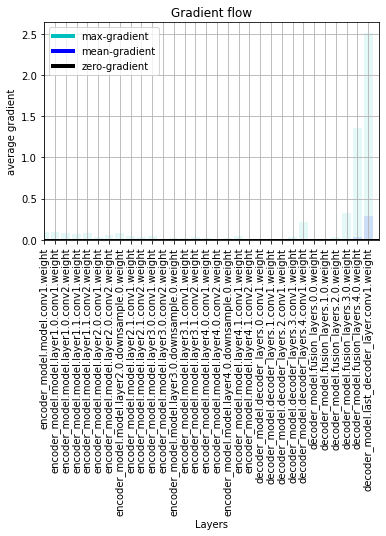

Iter: 10 | Train loss on last  10 : total - 25.988783740997313, content-27.57480068206787, style-23.231303691864014


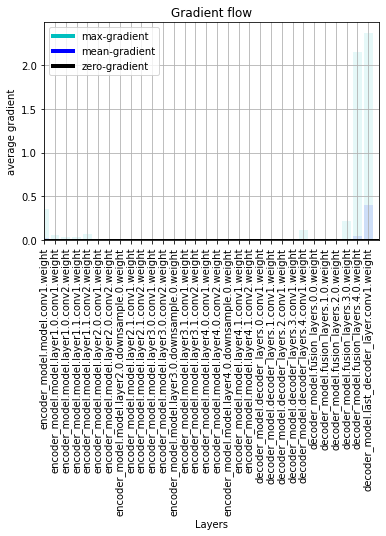

Iter: 20 | Train loss on last  10 : total - 37.07856531143189, content-31.863828277587892, style-33.89218282699585


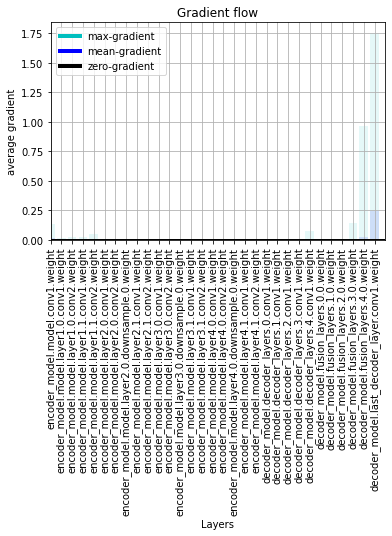

Iter: 30 | Train loss on last  10 : total - 27.484215641021727, content-27.13453826904297, style-24.770761680603027


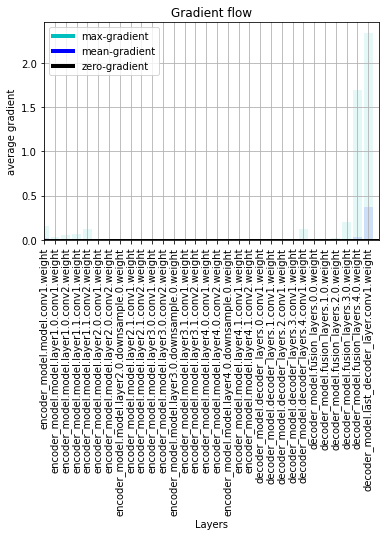

Iter: 40 | Train loss on last  10 : total - 34.11122236251831, content-27.30289306640625, style-31.38093309402466


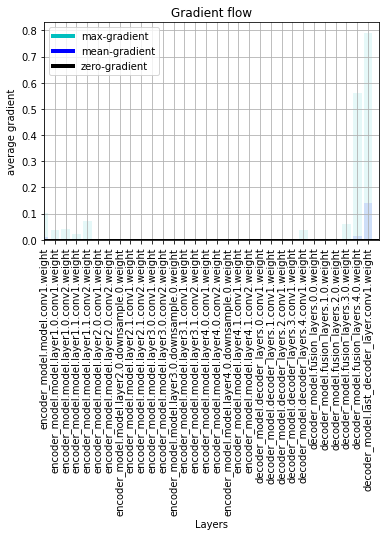

Iter: 50 | Train loss on last  10 : total - 18.15984516143799, content-26.6889009475708, style-15.490955305099487


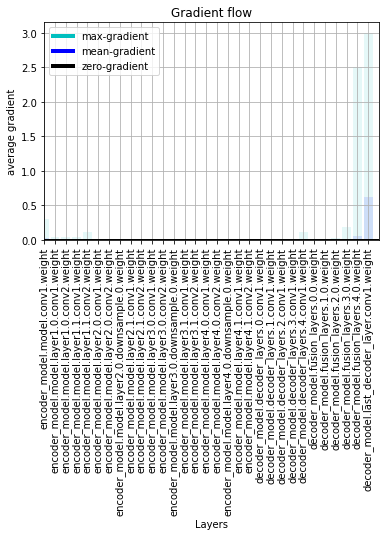

Iter: 60 | Train loss on last  10 : total - 18.000826025009154, content-28.382819175720215, style-15.16254415512085


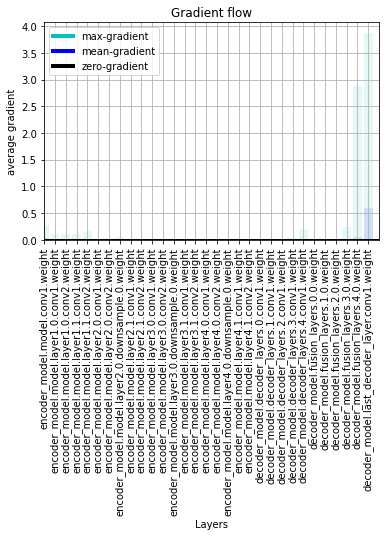

Iter: 70 | Train loss on last  10 : total - 25.599231004714966, content-26.766148185729982, style-22.922616147994994


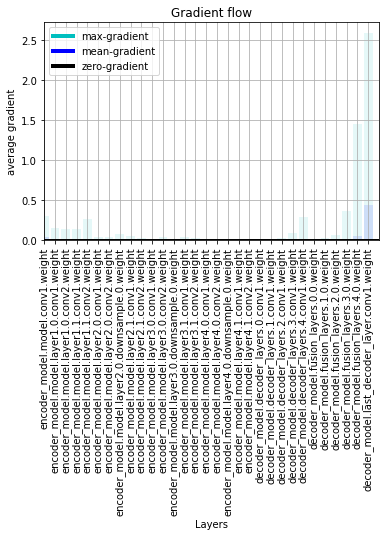

Iter: 80 | Train loss on last  10 : total - 28.296609592437743, content-29.134052276611328, style-25.383204460144043


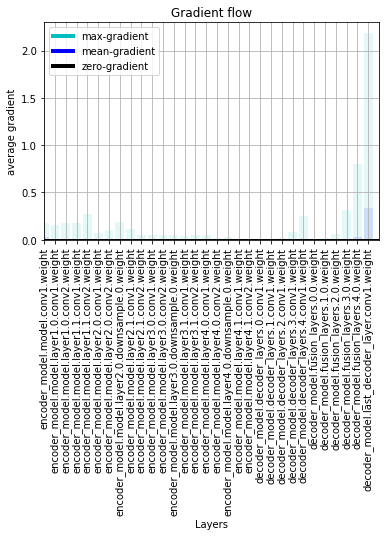

Iter: 90 | Train loss on last  10 : total - 15.04428939819336, content-24.8309024810791, style-12.56119909286499


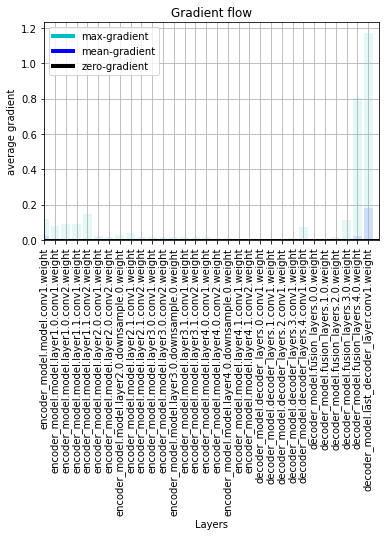

Iter: 100 | Train loss on last  10 : total - 20.046327209472658, content-27.353695678710938, style-17.31095790863037


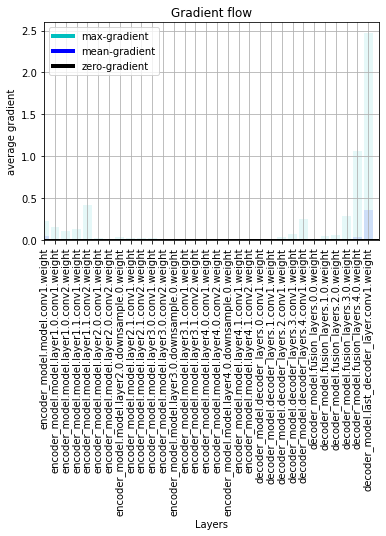

Iter: 110 | Train loss on last  10 : total - 23.178288650512695, content-25.50394172668457, style-20.627894401550293


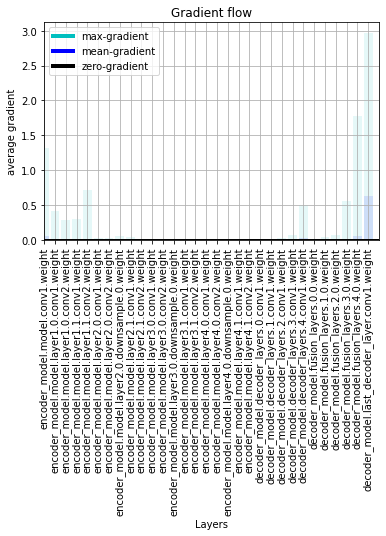

Iter: 120 | Train loss on last  10 : total - 20.819320964813233, content-25.76781635284424, style-18.24253969192505


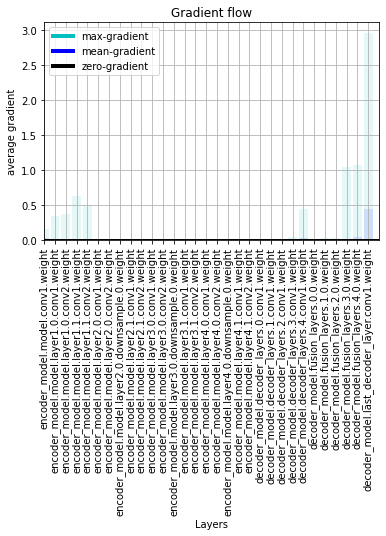

Iter: 130 | Train loss on last  10 : total - 18.398140048980714, content-26.609410095214844, style-15.737199020385741


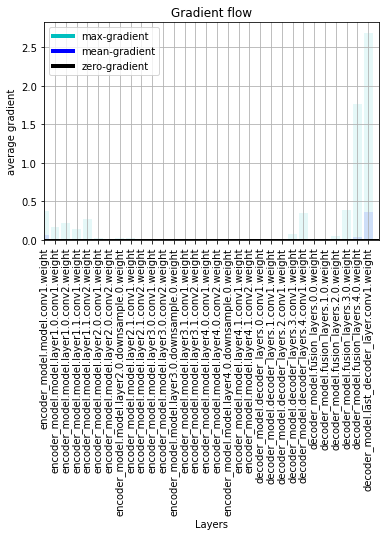

Iter: 140 | Train loss on last  10 : total - 15.344182348251342, content-26.249763679504394, style-12.719205832481384


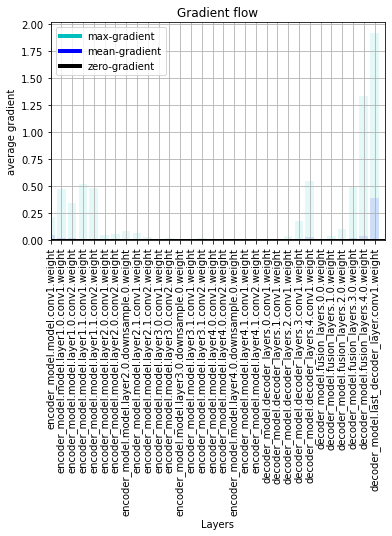

Iter: 150 | Train loss on last  10 : total - 16.37831768989563, content-25.01920986175537, style-13.876396632194519


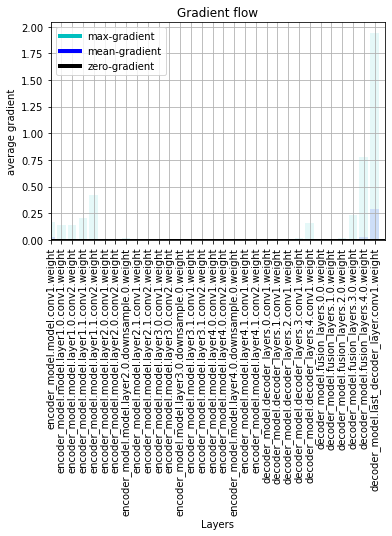

Iter: 160 | Train loss on last  10 : total - 16.10781955718994, content-24.7948148727417, style-13.62833788394928


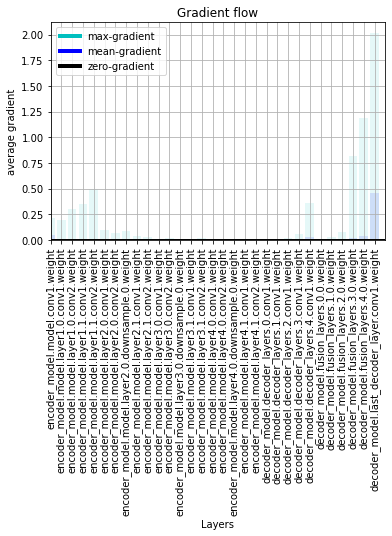

Iter: 170 | Train loss on last  10 : total - 26.38104066848755, content-24.2171688079834, style-23.95932412147522


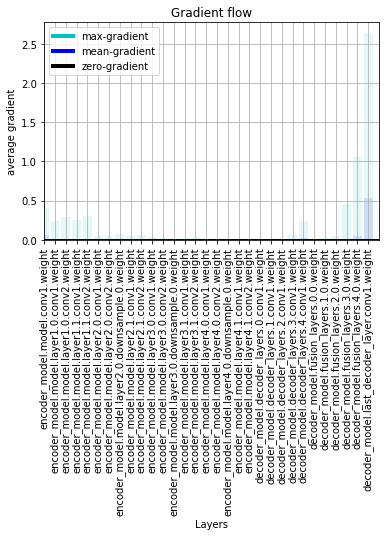

Iter: 180 | Train loss on last  10 : total - 23.6239013671875, content-27.042551040649414, style-20.919645977020263


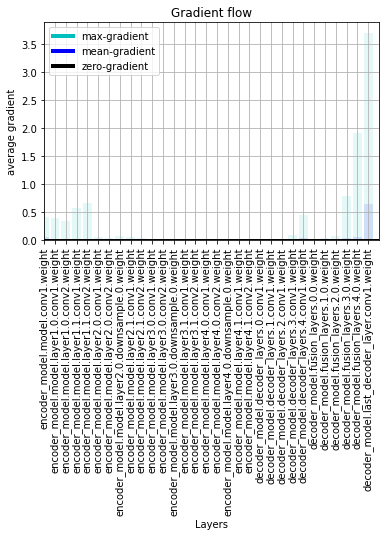

Iter: 190 | Train loss on last  10 : total - 22.59232168197632, content-26.27198991775513, style-19.965122389793397


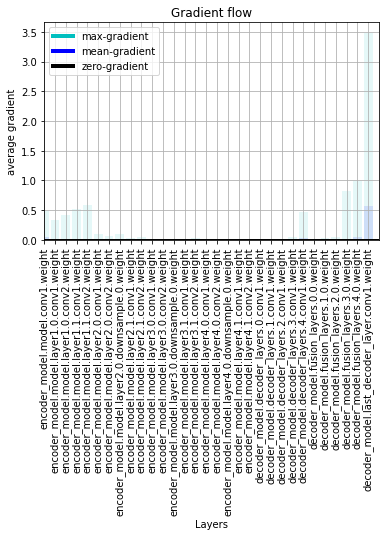

Iter: 200 | Train loss on last  10 : total - 16.25937147140503, content-23.995939636230467, style-13.859777784347534


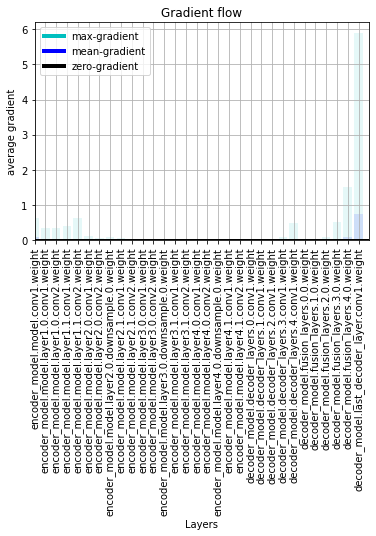

Iter: 210 | Train loss on last  10 : total - 17.906204891204833, content-25.426123809814452, style-15.363592481613159


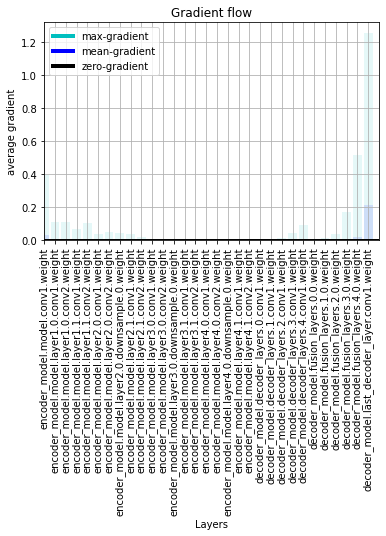

Iter: 220 | Train loss on last  10 : total - 17.379205226898193, content-26.185947799682616, style-14.760610485076905


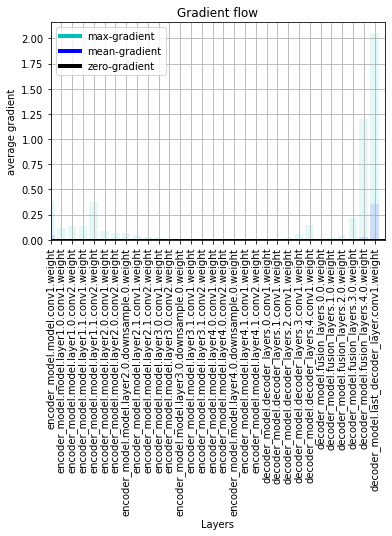

Iter: 230 | Train loss on last  10 : total - 19.608349657058717, content-24.336014175415038, style-17.17474834918976


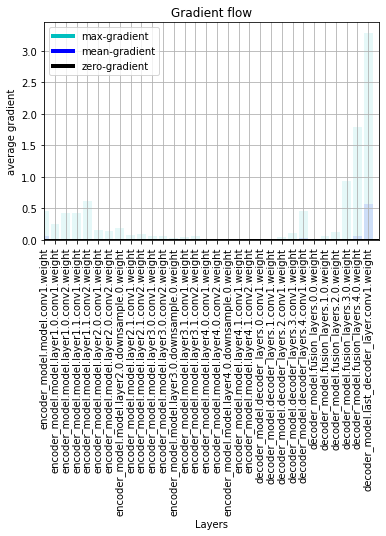

Iter: 240 | Train loss on last  10 : total - 13.248623418807984, content-23.43020706176758, style-10.90560245513916


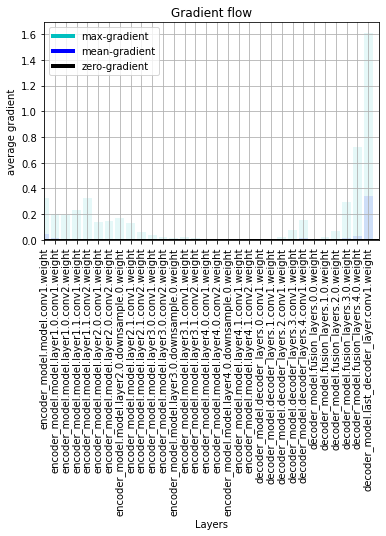

Iter: 250 | Train loss on last  10 : total - 12.05204792022705, content-23.24849452972412, style-9.727198362350464


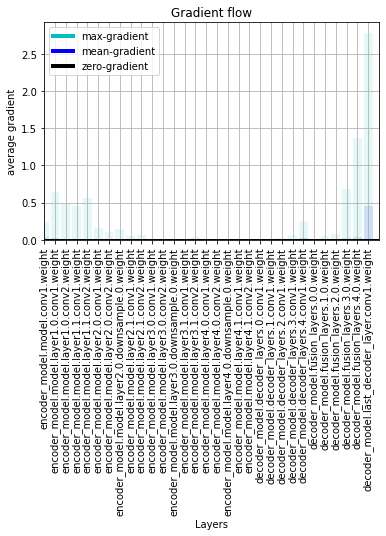

Iter: 260 | Train loss on last  10 : total - 15.731566834449769, content-22.210951042175292, style-13.510471761226654


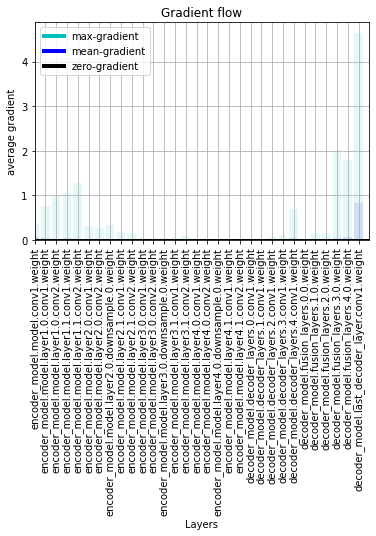

Iter: 270 | Train loss on last  10 : total - 17.288778686523436, content-26.569573974609376, style-14.631821084022523


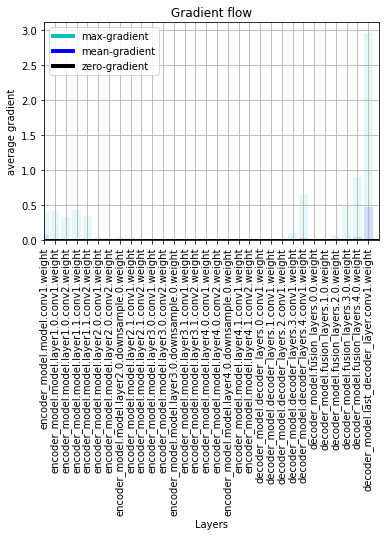

Iter: 280 | Train loss on last  10 : total - 15.311447882652283, content-20.98869915008545, style-13.212578117847443


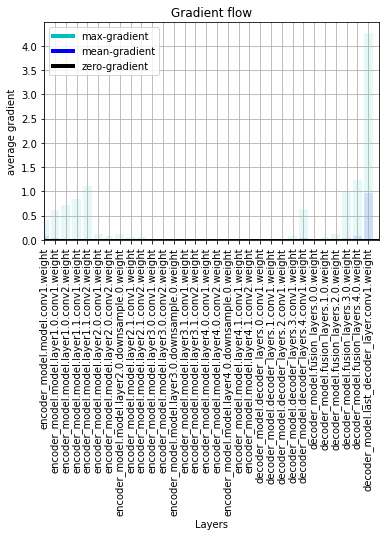

Iter: 290 | Train loss on last  10 : total - 17.712540674209595, content-25.622542572021484, style-15.150286293029785


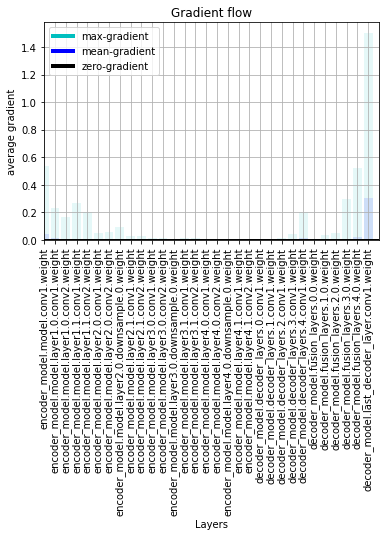

Iter: 300 | Train loss on last  10 : total - 15.996035766601562, content-24.025168228149415, style-13.593518590927124


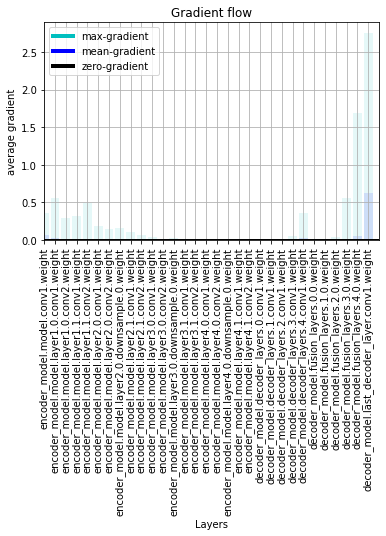

Iter: 310 | Train loss on last  10 : total - 18.50577383041382, content-24.101169776916503, style-16.095656967163087


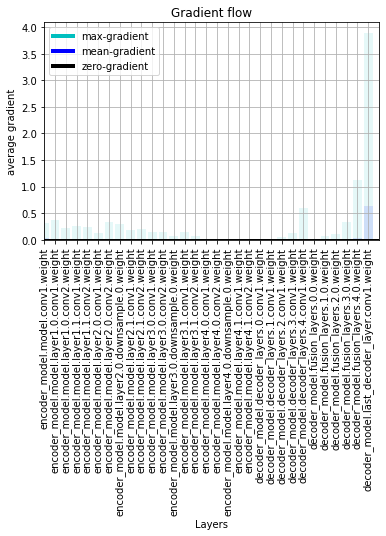

Iter: 320 | Train loss on last  10 : total - 26.275880908966066, content-27.047557640075684, style-23.57112545967102


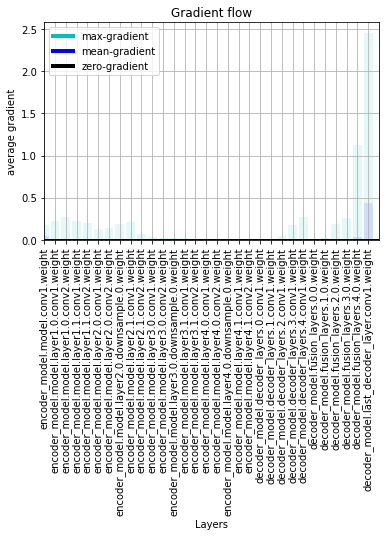

Iter: 330 | Train loss on last  10 : total - 15.565120363235474, content-22.554510498046874, style-13.309669184684754


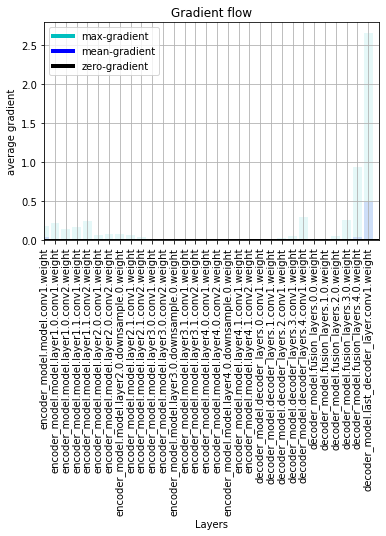

Iter: 340 | Train loss on last  10 : total - 20.777892684936525, content-23.00169849395752, style-18.47772271633148


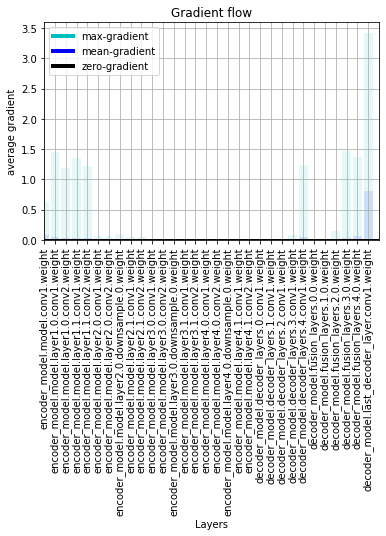

Iter: 350 | Train loss on last  10 : total - 20.60676817893982, content-26.26196880340576, style-17.980570983886718


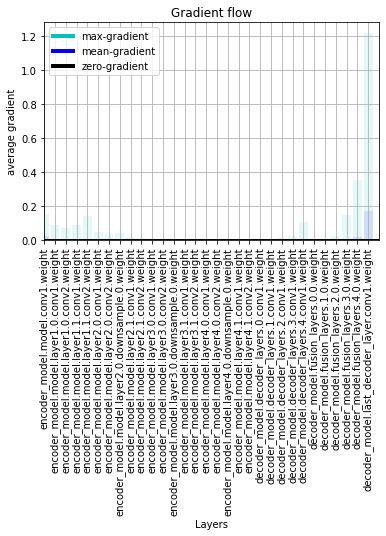

Iter: 360 | Train loss on last  10 : total - 22.902447032928468, content-24.655385971069336, style-20.436908531188966


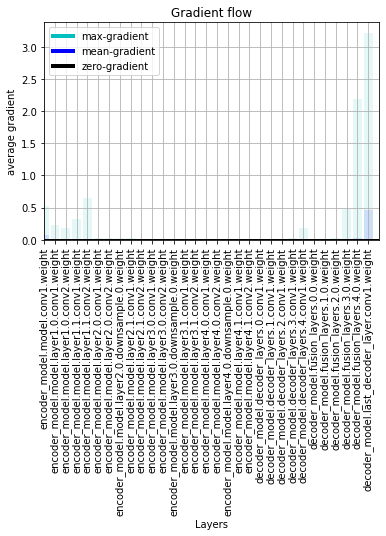

Iter: 370 | Train loss on last  10 : total - 15.464759731292725, content-24.1410493850708, style-13.05065450668335


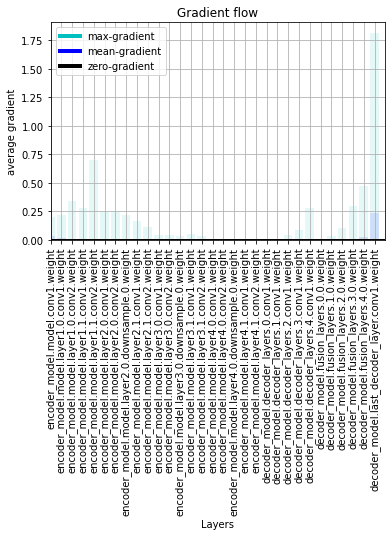

Iter: 380 | Train loss on last  10 : total - 18.55505499839783, content-23.694473457336425, style-16.18560802936554


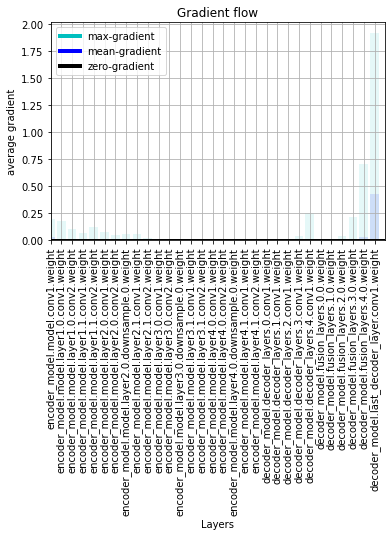

Iter: 390 | Train loss on last  10 : total - 17.169988870620728, content-22.354236030578612, style-14.93456529378891


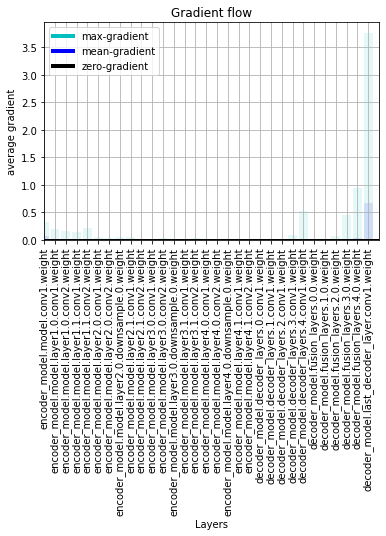

Iter: 400 | Train loss on last  10 : total - 16.106941890716552, content-23.51700439453125, style-13.755241394042969


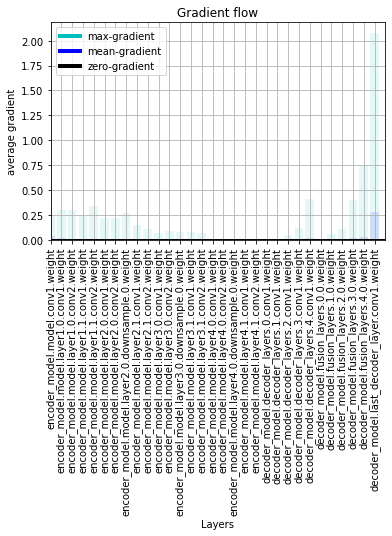

Iter: 410 | Train loss on last  10 : total - 13.69029393196106, content-24.092168617248536, style-11.281077086925507


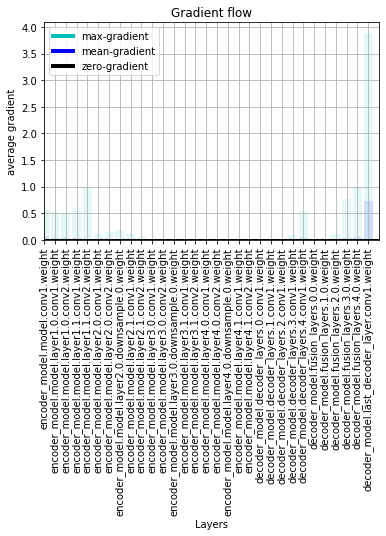

Iter: 420 | Train loss on last  10 : total - 22.9030818939209, content-25.96225700378418, style-20.30685634613037


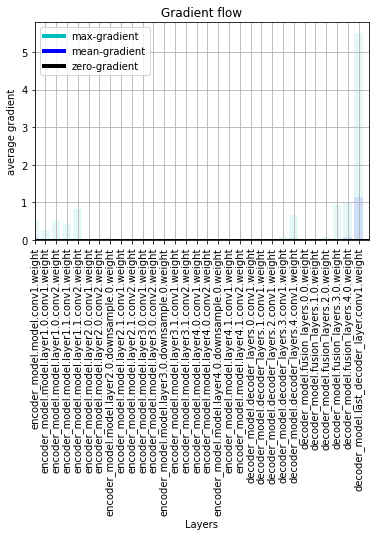

Iter: 430 | Train loss on last  10 : total - 14.861764001846314, content-22.53980407714844, style-12.60778374671936


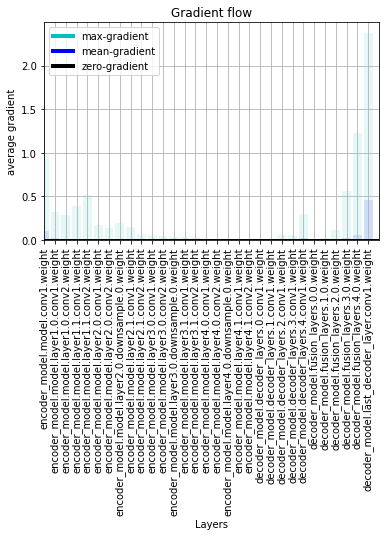

Iter: 440 | Train loss on last  10 : total - 18.364568758010865, content-24.98623104095459, style-15.865945410728454


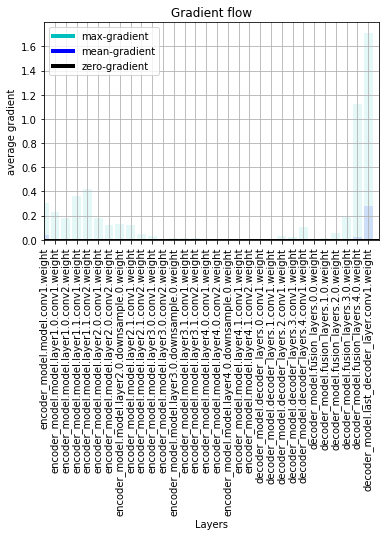

Iter: 450 | Train loss on last  10 : total - 14.553034448623658, content-22.61699457168579, style-12.291334986686707


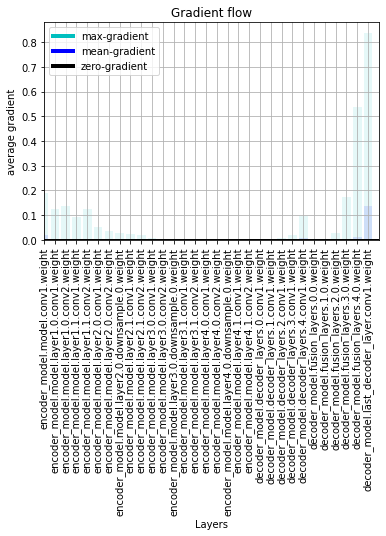

Iter: 460 | Train loss on last  10 : total - 20.866606664657592, content-26.97257137298584, style-18.169349813461302


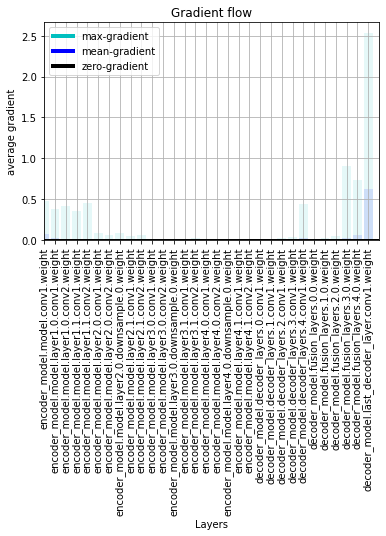

Iter: 470 | Train loss on last  10 : total - 18.645173645019533, content-24.99184513092041, style-16.145988845825194


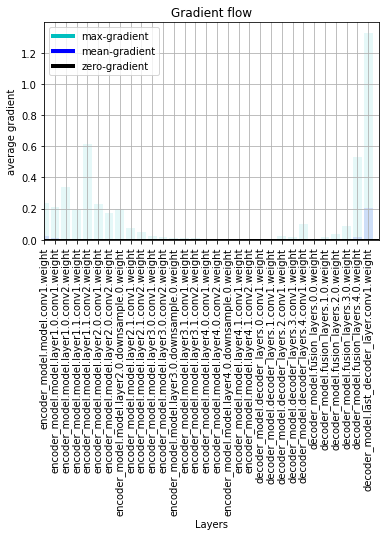

Iter: 480 | Train loss on last  10 : total - 14.056482982635497, content-25.704018783569335, style-11.486080837249755


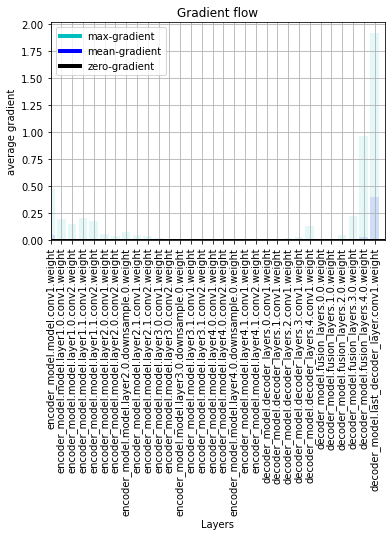

Iter: 490 | Train loss on last  10 : total - 18.760110759735106, content-24.691630172729493, style-16.29094796180725


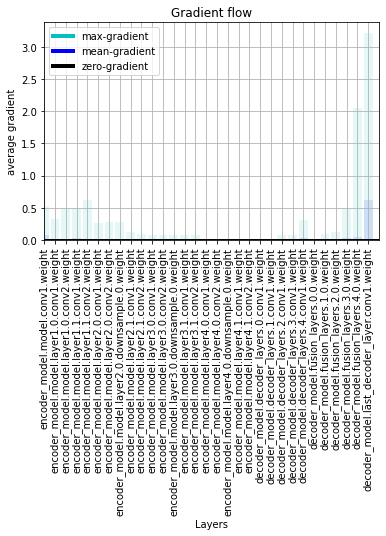

Iter: 500 | Train loss on last  10 : total - 18.27821855545044, content-25.985539817810057, style-15.679664611816406


In [38]:
main_model.weights = [1 for i in range(len(main_model.weights))]

main_model = train(main_model,
                  Adam,
                  dataset_train,
                  loss_model,
                  500,
                  batch_size=3,
                  lr=1e-4,
                  out_frequency=10,
                  alpha=0.1)

In [39]:
#main_model

In [40]:
#list(main_model.named_parameters())

In [41]:
#list(main_model.weights.named_parameters())

In [42]:
#w = [torch.clone(w.data) for w in main_model.weights]
#w

In [43]:
#main_model.weights[1].data = torch.zeros(1).to(DEVICE)
#main_model.weights[0].data

In [50]:
main_model = main_model.eval()

In [51]:
name = 'unet_model.pth'
torch.save(main_model.state_dict(), name)

In [52]:
#resnet = nn.Sequential(od)
##adain = AdainBlock(LAYERS_NAME)
#decoder = DecoderBlock(CHANNELS_SIZES)


#main_model = STUNet(vgg, adain, decoder, LAYERS_NAME, CHANNELS_SIZES)

In [53]:
#main_model.load_state_dict(torch.load(name))
#main_model = main_model.to(DEVICE)

In [54]:
#main_model


In [86]:
torch.cuda.empty_cache()
#normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                 std=[0.229, 0.224, 0.225])


contents, styles = dataset_test[1]
contents_t, styles_t = torch.unsqueeze(contents, 0).to(DEVICE), torch.unsqueeze(styles, 0).to(DEVICE)
main_model.weights = [1, 1, 1, 1, 1, 1]
out_img = main_model(normalize(contents_t), normalize(styles_t))[0]
#out_img = (out_img - torch.min(out_img)) / (torch.max(out_img)- torch.min(out_img))
print(torch.max(out_img), torch.min(out_img))
print(out_img.shape, contents.shape)
pil_img = transforms.ToPILImage()(out_img.detach())

#loss_model(normalize(contents_t),  normalize(styles_t), normalize(contents_t))

tensor(0.8740, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.0049, device='cuda:0', grad_fn=<MinBackward1>)
torch.Size([3, 512, 512]) torch.Size([3, 512, 512])


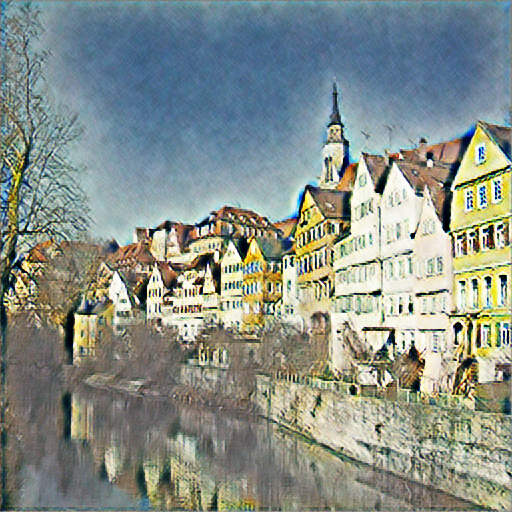

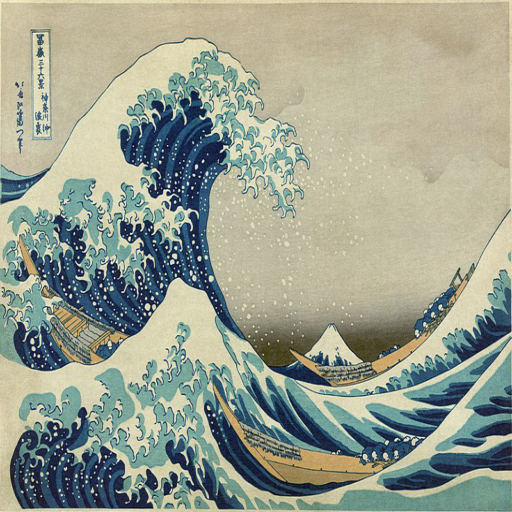

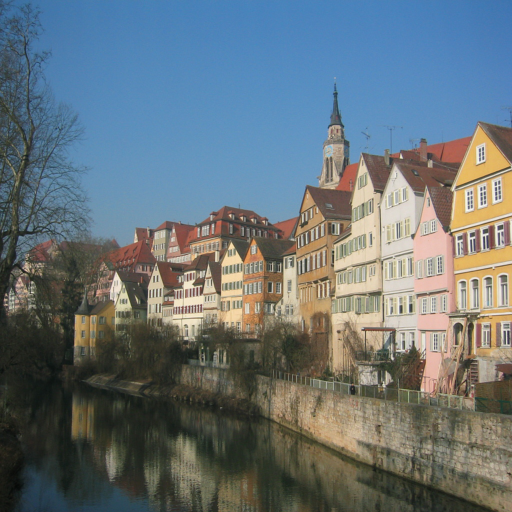

In [85]:
from IPython.display import display # to display images
display(pil_img)
display(transforms.ToPILImage()(styles))
display(transforms.ToPILImage()(contents))

In [ ]:
t = torch.Tensor([[1, 2], [3, 4]])
print(torch.mean(t, (1), keepdims=True))

In [ ]:
p = nn.Parameter(torch.randn(1))

In [ ]:
p.data.item()

In [ ]:
a = torch.randn(2, 54, 224, 224)
a = a.view(2, 54, -1)

In [ ]:
a.shape

In [ ]:
from graphviz import Digraph
import torch
from torch.autograd import Variable, Function

def iter_graph(root, callback):
    queue = [root]
    seen = set()
    while queue:
        fn = queue.pop()
        if fn in seen:
            continue
        seen.add(fn)
        for next_fn, _ in fn.next_functions:
            if next_fn is not None:
                queue.append(next_fn)
        callback(fn)

def register_hooks(var):
    fn_dict = {}
    def hook_cb(fn):
        def register_grad(grad_input, grad_output):
            fn_dict[fn] = grad_input
        fn.register_hook(register_grad)
    iter_graph(var.grad_fn, hook_cb)

    def is_bad_grad(grad_output):
        if grad_output is None:
            return False
        return grad_output.isnan().any() or (grad_output.abs() >= 1e6).any()

    def make_dot():
        node_attr = dict(style='filled',
                        shape='box',
                        align='left',
                        fontsize='12',
                        ranksep='0.1',
                        height='0.2')
        dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))

        def size_to_str(size):
            return '('+(', ').join(map(str, size))+')'

        def build_graph(fn):
            if hasattr(fn, 'variable'):  # if GradAccumulator
                u = fn.variable
                node_name = 'Variable\n ' + size_to_str(u.size())
                dot.node(str(id(u)), node_name, fillcolor='lightblue')
            else:
                assert fn in fn_dict, fn
                fillcolor = 'white'
                if any(is_bad_grad(gi) for gi in fn_dict[fn]):
                    fillcolor = 'red'
                dot.node(str(id(fn)), str(type(fn).__name__), fillcolor=fillcolor)
            for next_fn, _ in fn.next_functions:
                if next_fn is not None:
                    next_id = id(getattr(next_fn, 'variable', next_fn))
                    dot.edge(str(next_id), str(id(fn)))
        iter_graph(var.grad_fn, build_graph)

        return dot

    return make_dot

x = torch.randn(10, 10, requires_grad=True)
y = torch.randn(10, 10, requires_grad=True)

z = x / (y * 0)
z = z.sum() * 2
get_dot = register_hooks(z)
z.backward()
dot = get_dot()
#dot.save('tmp.dot') # to get .dot
#dot.render('tmp') # to get SVG
dot # in Jupyter, you can just render the variable



In [ ]:
a = torch.Tensor([[[1,2],
                  [3, 4]]])
a.shape

In [ ]:
a.mean(dim=(-1,-2), keepdims=True)

In [ ]:
#def fuse_two_nets(net1, net2, alpha):



In [ ]:

    #normalize = nn.Sequential(transforms.Normalize(mean=, , ],
    #                             std=[0.229, 0.224, 0.225]))

In [ ]:
example = torch.randn(2, 3, 256, 256)

In [ ]:
(example - mu ) / std